# Business Understanding

## Brief description
Milan is the second largest city in Italy and there are approximately 10 thousands apartments listed on Air-bnb (based on the Milan Airbnb Open Data Dateset on Kaggle) 


in this notebook we are going to answer the following questions


## Question 1
Does being closer to the center mean higher daily price?


## Question 2
Does being closer to the center mean higher review score?


## Question 3
Can the daily price of a new listing be predicted?

# Data Understaing

In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [5]:
#importing dataset of Airbnb
df = pd.read_csv('/content/drive/MyDrive/Milano/Airbnb_Milan.csv')
df = df.set_index('index')

In [6]:
#checking if there are some null values
df.isnull().mean().sum()
# no null values in the dataset

0.0

In [8]:
#checking if there are some null values 
df.dtypes
# all the columns are numerical except one (room_type)

id                                    int64
host_id                               int64
host_location                         int64
host_response_time                    int64
host_response_rate                    int64
host_is_superhost                     int64
host_total_listings_count             int64
host_has_profile_pic                  int64
host_identity_verified                int64
neighbourhood_cleansed                int64
zipcode                               int64
latitude                            float64
longitude                           float64
room_type                            object
accommodates                          int64
bathrooms                             int64
bedrooms                              int64
beds                                  int64
bed_type                              int64
daily_price                           int64
security_deposit                      int64
cleaning_fee                          int64
guests_included                 

In [9]:
#first analysis of the data
df.describe()


,id,host_id,host_location,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,bed_type,daily_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,TV,WiFi,Air_Condition,Wheelchair_accessible,Kitchen,Breakfast,Elevator,Heating,Washer,Iron,Host_greets_you,Paid_parking_on_premises,Luggage_dropoff_allowed,Long_term_stays_allowed,Doorman,Pets_allowed,Smoking_allowed,Suitable_for_events,24_hour_check_in
count,9.322000e+03,9.322000e+03,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000,9322.000000
mean,1.908042e+07,6.623391e+07,0.959558,0.869234,53.256919,0.288887,23.186977,0.999571,0.431238,4.504398,20136.439820,45.471231,9.187270,3.589895,3.356790,1.218086,2.097511,1.028964,103.735143,21.709504,43.533576,1.724952,13.286956,3.205321,13.609526,30.569835,48.940034,184.783094,39.640742,93.147930,9.597940,9.457091,9.678181,9.697812,9.488307,9.204892,0.584960,0.857541,0.014589,0.023600,0.872452,0.928556,0.727634,0.042158,0.967282,0.172817,0.614782,0.980691,0.810341,0.812057,0.450011,0.144390,0.201566,0.302939,0.162733,0.217121,0.107273,0.036366,0.085282
std,1.080544e+07,7.686396e+07,0.197004,0.337162,10.365986,0.453269,96.380476,0.020711,0.495276,2.655209,12.428803,0.019397,0.028098,1.561154,0.979969,0.731942,1.273565,0.200359,137.956457,32.780475,25.046306,1.017431,15.221567,13.749608,10.487724,20.614389,30.030045,121.728065,65.597271,8.337679,0.798902,0.870510,0.723903,0.724584,0.756705,0.917978,0.492755,0.349539,0.119908,0.151808,0.333603,0.257579,0.445201,0.200961,0.177908,0.378109,0.486673,0.137617,0.392052,0.390687,0.497521,0.351503,0.401191,0.459554,0.369142,0.412308,0.309477,0.187208,0.279316
min,2.398600e+04,2.405400e+04,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20021.000000,45.394790,9.068770,1.000000,1.000000,0.000000,0.000000,1.000000,10.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.225660e+06,9.780440e+06,1.000000,1.000000,57.000000,0.000000,1.000000,1.000000,0.000000,2.000000,20124.000000,45.455490,9.170685,2.000000,3.000000,1.000000,1.000000,1.000000,59.000000,1.000000,30.000000,1.000000,0.000000,1.000000,3.000000,11.000000,25.000000,75.000000,4.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.079747e+07,2.789633e+07,1.000000,1.000000,57.000000,0.000000,2.000000,1.000000,0.000000,4.000000,20135.000000,45.471

In [33]:
#importing map of milan
street_map = gpd.read_file('/content/drive/MyDrive/Milano/milano/gis_osm_roads_free_1.shp')

# Prepare Data

In [12]:
def prepare_data(df,target):
  '''
  INPUT
  df - pandas dataframe 
  target - target variable
    
  OUTPUT
  X - A matrix holding all of the variables you want to consider when predicting the response
  y - the corresponding response vector
  df_cleaned - the dataframe cleaned
   
  Perform to obtain the correct X and y objects
  This function cleans df using the following steps to produce X and y:
  1. Drop all the rows with no daily price
  2. For each numeric variable in df, fill the column with the mean value of the column.
  3. Create dummy columns for all the categorical variables in df, drop the original columns
  4. Create X as all the columns that are not the Daily Price column
  5. Create y as the Daily Price column
  '''

  df = df.dropna(subset = [target], axis=0)

  num_cols = df.select_dtypes(include = ['float', 'int']).columns
  for col in num_cols:
    df[col].fillna((df[col].mean()), inplace = True)

  cat_cols = df.select_dtypes(include = ['object']).copy().columns
  for col in cat_cols:
    df = pd.concat([df.drop(col,axis = 1), pd.get_dummies(df[col], prefix = col, prefix_sep = '_', drop_first = True)], axis = 1)

  X = df.copy()
  y = df[target].copy()
  return X,y,df

In [28]:
#target variable is for the modeling part
target = 'daily_price'
X, y, df = prepare_data(df,target)

# Data Modeling

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [23]:
def create_predictions(X,y,test_size =0.2, n_estimators = 1500, max_depth = 5):
  '''
  INPUT
  X - A matrix holding all of the variables you want to consider when predicting the response
  y - the corresponding response vector
  test_size - size of the test dataset
  n_estimators - hyperparameter for number of tree in random forest
  max_depth - hyperparameter for max depth in random forest
    
  OUTPUT
  X_train - the part of X that you want to use for training
  X_test - the part of X that you want to use for testing
  y_train - the part of y that you want to use for training
  y_test - the part of y that you want to use for testing
   y_pred = prediction of the model
    
  Perform to obtain the correct X and y objects
  This function cleans df using the following steps to produce X and y:
  1. create train and test dataset
  2. initiate the random forest.
  3. fit the model
  4. use the model to make predictions
  '''

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  RFR = RandomForestRegressor(n_estimators = n_estimators,max_depth=1500,random_state = 0)
  RFR.fit(X_train,y_train)
  y_pred = RFR.predict(X_test)
  return X_train, X_test, y_train, y_test, y_pred

In [24]:
X_train, X_test, y_train, y_test, y_pred = create_predictions(X,y,0.2,1500,5)

In [25]:
def calculate_metrics(y_test,y_pred):

  '''
  INPUT
  y_test - the correct predictions of the test dataset
  y_pred - prediction of the model
    
  OUTPUT
  MAE
  MSE
  RMSE
  MAPE
  Accuracy 
    
  Perform to obtain the correct X and y objects
  This function cleans df using the following steps to produce X and y:
  1. Calculate metrics for the model
  
  '''

  MAE = metrics.mean_absolute_error(y_test, y_pred)
  MSE = metrics.mean_squared_error(y_test, y_pred)
  RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
  mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_test)))
  MAPE = round(mape * 100, 2)
  Accuracy = round(100*(1 - mape), 2)
  
  
  print('Mean Absolute Error (MAE):', MAE)
  print('Mean Squared Error (MSE):', MSE)
  print('Root Mean Squared Error (RMSE):', RMSE)
  print('Mean Absolute Percentage Error (MAPE):', MAPE)
  print('Accuracy:', Accuracy)

  return MAE, MSE, RMSE, MAPE, Accuracy

In [26]:
MAE, MSE, RMSE, MAPE, Accuracy = calculate_metrics(y_test,y_pred)

Mean Absolute Error (MAE): 0.36723109919571045
Mean Squared Error (MSE): 26.47010750479597
Root Mean Squared Error (RMSE): 5.144910835456332
Mean Absolute Percentage Error (MAPE): 0.06
Accuracy: 99.94


# Evaluation

## Does being closer to the center mean higher daily price?

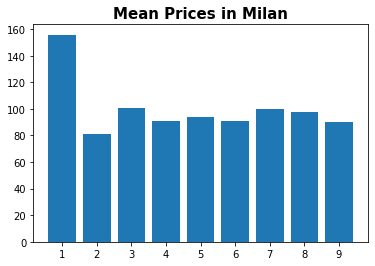

In [29]:
#checking the avarage price related to the neighbourhood
df_price = df.groupby('neighbourhood_cleansed').mean().reset_index()


fig, ax = plt.subplots()
ax.bar(df_price['neighbourhood_cleansed'],df_price['daily_price'])
ax.set_xticks(df_price['neighbourhood_cleansed'])
plt.title('Mean Prices in Milan', fontsize=15,fontweight='bold')
plt.savefig('Mean Price')
plt.show()

the neighbourhood number 1 appears to have an higher (almost double) avarege mean daily price compared to the others

Let's do a more detailed analysis using a map of Milan in order to understand better the distrution

In [35]:
#defining threshold 
max_threshold = df['daily_price'].quantile(0.95)
min_threshold = df['daily_price'].quantile(0.05)

#using threshold to create new dataset
df_new = df[(df['daily_price']> min_threshold) & (df['daily_price']<max_threshold)].copy()

#creating log10 and log of price
df_new['log10_daily_price'] = np.log10(df_new['daily_price'])
df_new['log_daily_price'] = np.log(df_new['daily_price'])

In [37]:
#Creation of coordinate system for the map
crs = {'init':'epsg:4326'}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df_new['longitude'], df_new['latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df_new,
 crs = crs,
 geometry = geometry)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


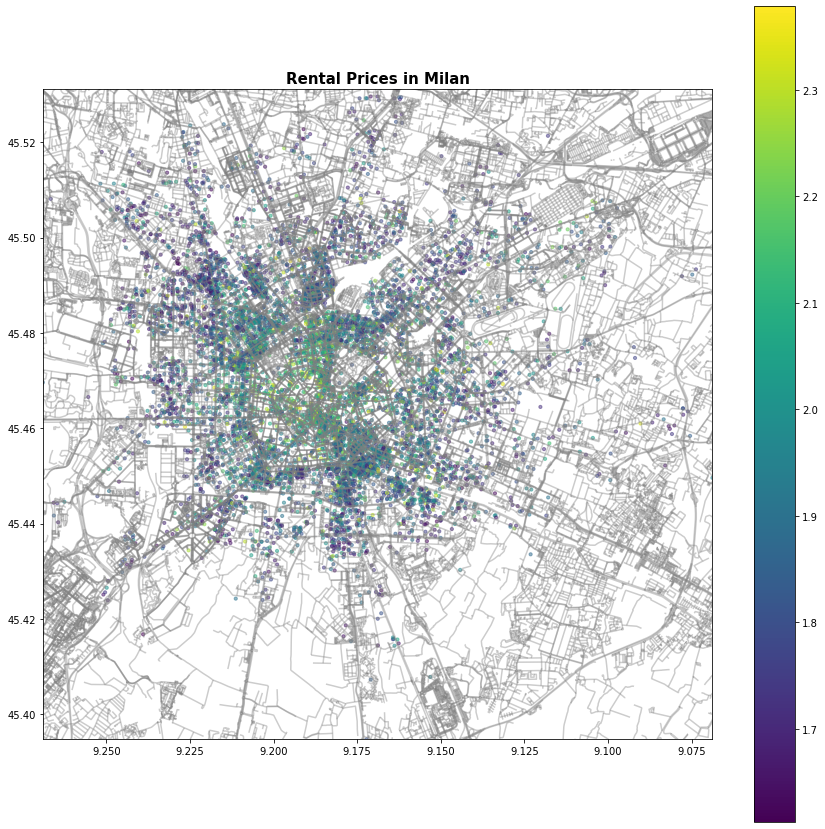

In [38]:
#create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')
# add geodataframe to axes
# assign ‘log10_daily_price’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df.plot(column='log10_daily_price',ax=ax,alpha=0.5, legend=True,markersize=10)
# add title to graph
plt.title('Rental Prices in Milan', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(9.26897,9.068769999999999)
plt.ylim( 45.39479,45.53116)


# show map
plt.savefig('Prices Map')
plt.show()

As we can see, Prices depend on how far the apartment is from the city center, and the further the apartment is from it, the lower the price

## Does being closer to the center means having a better review score?

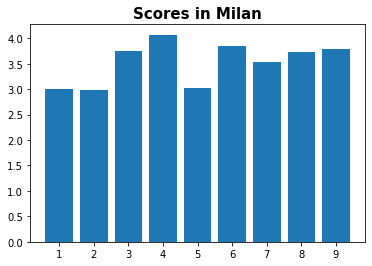

In [39]:
#remove apartments with less then 5 reviews
df_reviews = df[df['number_of_reviews']>5].copy()

#calculate mean,mix,max of the neighbourhood
df_revies_2 = df_reviews.groupby('neighbourhood_cleansed').mean().reset_index()
df_revies_min = df_reviews.groupby('neighbourhood_cleansed').min().reset_index()
df_revies_max = df_reviews.groupby('neighbourhood_cleansed').max().reset_index()

#subtract 90 to see better the values
df_revies_2['new_score'] = df_revies_2['review_scores_rating']-90


#plot the mean
fig, ax = plt.subplots()
ax.bar(df_price['neighbourhood_cleansed'],df_revies_2['new_score'])
ax.set_xticks(df_price['neighbourhood_cleansed'])
plt.title('Scores in Milan', fontsize=15,fontweight='bold')
plt.savefig('Scores in Milan')
plt.show()

The score doesn't appear to have a relation with the neighbourhood, on the contrary, apartments on the city center have one of the lowest score

In [40]:
# designate coordinate system
crs = {'init':'epsg:4326'}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df_reviews['longitude'], df_reviews['latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df_reviews,
 crs = crs,
 geometry = geometry)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


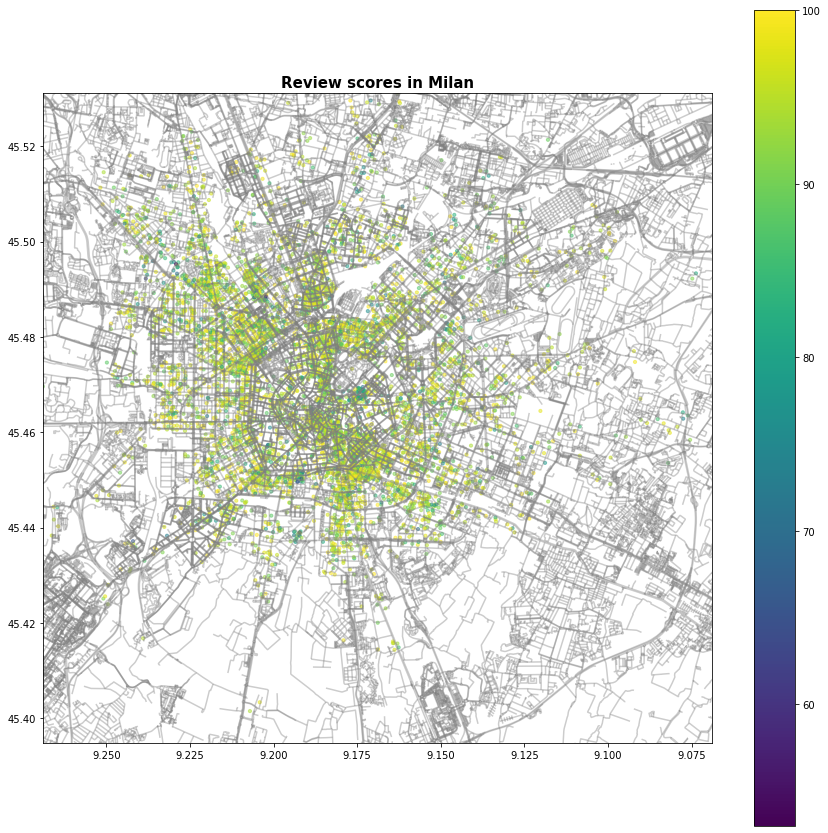

In [41]:
#create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')
# add geodataframe to axes
# assign ‘review_scores_rating’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df.plot(column='review_scores_rating',ax=ax,alpha=0.5, legend=True,markersize=10)
# add title to graph
plt.title('Review scores in Milan', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(9.26897,9.068769999999999)
plt.ylim( 45.39479,45.53116)


# show map
plt.savefig('Rental Scores Milan')
plt.show()

AS we can see from the map above, review score doesn't appear to be related to the neighbourhood


## Can we predict the value of a new house?

let's analyse the metrics of our model based on the test dataset

In [42]:
  print('Mean Absolute Error (MAE):', MAE)
  print('Mean Squared Error (MSE):', MSE)
  print('Root Mean Squared Error (RMSE):', RMSE)
  print('Mean Absolute Percentage Error (MAPE):', MAPE)

Mean Absolute Error (MAE): 0.36723109919571045
Mean Squared Error (MSE): 26.47010750479597
Root Mean Squared Error (RMSE): 5.144910835456332
Mean Absolute Percentage Error (MAPE): 0.06


As we can see from the metrics above, our model is quite effective at predicting the daily price of a new listing